In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
from torchvision import datasets
from torchvision import transforms

data_path = './data/'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True, transform=transforms.ToTensor())
cifar10_validation = datasets.CIFAR10(data_path, train=False, download=True, transform=transforms.ToTensor())

label_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

Files already downloaded and verified
Files already downloaded and verified


In [3]:
label_map = {0:0, 3:1}
class_names = ['airplane', 'cat']
cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0,3]]
cifar2_validation = [(img, label_map[label]) for img, label in cifar10_validation if label in [0,3]]

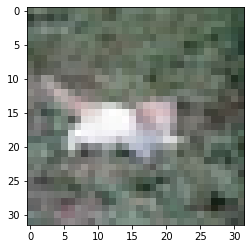

cat


In [23]:
img, label = cifar2[10]
plt.imshow(img.permute(1,2,0))
plt.show()
print(class_names[label])

In [36]:
import torch.nn.functional as F

class ResBlockPlain(nn.Module):
    def __init__(self, input_channels, channel_factor=1, stride=1):
        super().__init__()
        self.channel_factor = channel_factor
        self.stride = stride

        out_channels = input_channels * channel_factor
        self.conv1 = nn.Conv2d(
            input_channels,
            out_channels,
            kernel_size=3, padding=1, stride=stride
        )
        self.conv2 = nn.Conv2d(
            out_channels,
            out_channels,
            kernel_size=3, padding=1, stride=1
        )
        torch.nn.init.kaiming_normal_(self.conv1.weight, nonlinearity="relu")
        torch.nn.init.kaiming_normal_(self.conv2.weight, nonlinearity="relu")

        if stride != 1:
            self.downsample = nn.MaxPool2d(stride,stride)
        if channel_factor != 1:
            self.cut = self.shortcut(input_channels, out_channels)

    def forward(self, x):
        out = self.conv1(x)
        out = F.relu(out)
        out = self.conv2(out)
        if self.stride != 1:
            x = self.downsample(x)
        if self.channel_factor != 1:
            x = self.cut(x)
        out += x
        out = F.relu(out)
        return out

    def shortcut(self, input_channels, output_channels):
        return nn.Conv2d(input_channels, output_channels, kernel_size=1, padding=0)


class ResBlock(nn.Module):
    def __init__(self, input_channels, channel_factor, stride=1):
        super(ResBlock, self).__init__()

        self.channel_factor = channel_factor
        self.stride = stride

        first_out_channels = input_channels * channel_factor // 4

        self.conv1 = nn.Conv2d(
            input_channels, 
            first_out_channels,
            kernel_size=1, padding=0, stride=1
        )
        self.bn1 = nn.BatchNorm2d(first_out_channels)

        self.conv2 = nn.Conv2d(
            first_out_channels, 
            first_out_channels,
            kernel_size=3, padding=1, stride=stride
        )
        self.bn2 = nn.BatchNorm2d(first_out_channels)

        self.conv3 = nn.Conv2d(
            first_out_channels, 
            first_out_channels * 4,
            kernel_size=1, padding=0, stride=1
        )
        self.bn3 = nn.BatchNorm2d(first_out_channels * 4)

        self.downsample = nn.AvgPool2d(kernel_size=1, stride=stride)

        torch.nn.init.kaiming_normal_(self.conv1.weight, nonlinearity="relu")
        torch.nn.init.kaiming_normal_(self.conv2.weight, nonlinearity="relu")
        torch.nn.init.kaiming_normal_(self.conv3.weight, nonlinearity="relu")
        torch.nn.init.zeros_(self.bn1.bias)
        torch.nn.init.zeros_(self.bn2.bias)
        torch.nn.init.zeros_(self.bn3.bias)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = F.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)

        if self.channel_factor > 1:
            mapping = torch.zeros_like(out)
            mapping[:,:x.shape[1],:,:] = self.downsample(x)
            out += mapping
        else:
            out += x

        out = F.relu(out)

        return out


class NetResDeep(nn.Module):
    def __init__(self):
        super().__init__()
        # self.pool1 = nn.MaxPool2d(2,2)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1, stride=2)
        self.resblocks1 = nn.Sequential(
            *(6 * [ResBlockPlain(32)])
        )
        self.resblocks2 = ResBlockPlain(32, 2, stride=2)
        self.resblocks3 = nn.Sequential(
            *(8 * [ResBlockPlain(64, 1)])
        )
        self.resblocks4 = ResBlockPlain(64, 2, stride=2)
        self.resblocks5 = nn.Sequential(
            *(8 * [ResBlockPlain(128, 1)])
        )
        self.fc1 = nn.Linear(4*4*128, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        out = self.conv1(x)
        out = F.relu(out)
        # out = self.pool1(out)
        # out = F.max_pool2d(out, 2)
        out = self.resblocks1(out)
        out = self.resblocks2(out)
        out = self.resblocks3(out)
        out = self.resblocks4(out)
        out = self.resblocks5(out)
        flatten = nn.Flatten()
        out = flatten(out)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        return out

In [5]:
device = (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
device

device(type='cuda')

In [6]:
import datetime

def training_loop(n_epochs: int, optimizer, model, loss_fn, train_loader, validate_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()

        if epoch == 1 or epoch % 5 == 0:

            print(f"{datetime.datetime.now()} Epoch {epoch}: Training loss {loss_train / len(train_loader)}")
            validate(model, train_loader, validate_loader)

def validate(model, train_loader, validate_loader):
    model.eval()
    for name, loader in [("train", train_loader), ("val", validate_loader)]:
        correct = 0
        total = 0
        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels
                outputs = model(imgs).cpu()
                predicted = np.argmax(outputs.numpy(), axis=1)
                total += labels.shape[0]

                correct += int((predicted == labels.numpy()).sum())

            print(f"{name} acc: {correct / total:.3f}")
    model.train()

In [37]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=256, shuffle=True)
validate_loader = torch.utils.data.DataLoader(cifar2_validation, batch_size=256, shuffle=False)

model = NetResDeep().to(device=device)
if device == "cuda":
    model = torch.nn.DataParallel(model)
# model = Net().to(device=device)
# model.load_state_dict(torch.load(data_path + "cifar2_res.pt"))
optimizer = optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs=50,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader,
    validate_loader=validate_loader
)

torch.save(model.state_dict(), data_path + "cifar2_res.pt")

2022-05-16 03:37:14.805626 Epoch 1: Training loss 177.347396504879
train acc: 0.652
val acc: 0.652
2022-05-16 03:37:21.476997 Epoch 5: Training loss 0.40984014198184016
train acc: 0.831
val acc: 0.827
2022-05-16 03:37:29.734540 Epoch 10: Training loss 0.3345222719013691
train acc: 0.856
val acc: 0.838
2022-05-16 03:37:38.006441 Epoch 15: Training loss 0.27099907025694847
train acc: 0.903
val acc: 0.849
2022-05-16 03:37:46.249940 Epoch 20: Training loss 0.23350703790783883
train acc: 0.926
val acc: 0.856
2022-05-16 03:37:54.567007 Epoch 25: Training loss 0.20084048695862294
train acc: 0.928
val acc: 0.856
2022-05-16 03:38:02.788665 Epoch 30: Training loss 0.18028815612196922
train acc: 0.944
val acc: 0.860
2022-05-16 03:38:11.000281 Epoch 35: Training loss 0.1882568622007966
train acc: 0.957
val acc: 0.859
2022-05-16 03:38:19.251253 Epoch 40: Training loss 0.0938527244143188
train acc: 0.941
val acc: 0.845
2022-05-16 03:38:27.510642 Epoch 45: Training loss 0.041305905138142404
train acc